In [2]:
import os, gc , pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back ,Style
from matplotlib.ticker import MaxNLocator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error


DATA_DIR = "./input/"
FP_CELL_METADATA = os.path.join(DATA_DIR, "metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR , "train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR, "train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR, "test_cite_inputs.h5")


FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR, "train_mulit_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR, "train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR, "test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR, "sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR, "evaluation_ids.csv")



In [17]:
!pip install --quiet tables

In [9]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

((119651, 5), (161877, 5))

In [12]:
cite_te

array([[ 2.6035219e+01, -2.2196609e+01, -1.4293990e+01, ...,
        -6.4356339e-01,  8.8486922e-01, -1.8189380e+00],
       [ 3.4183872e+01, -2.0873419e+01, -1.4842298e+01, ...,
        -1.0012966e+00, -6.2334671e+00,  4.4651437e-01],
       [ 1.8631920e+00, -3.5000777e+00,  2.6588690e+01, ...,
         1.9775916e+00, -1.2665623e+00,  7.6803318e-03],
       ...,
       [-1.0423562e+01, -2.4237614e+00,  3.2403732e+01, ...,
         2.6679780e+00,  2.9493260e+00, -4.6040025e+00],
       [-2.0739750e+01,  2.6669426e+01,  4.0807004e+00, ...,
         1.2279660e+00,  3.2453087e-01, -2.2156374e+00],
       [ 1.9321787e+01, -8.0937853e+00,  2.7156519e+01, ...,
        -1.8838143e+00,  2.6665366e+00,  4.0614767e+00]], dtype=float32)

In [11]:

cite_train_y

array([[ 1.1678035 ,  0.62253   ,  0.10695851, ...,  0.41429165,
         1.780314  ,  0.5480701 ],
       [ 0.81897014,  0.50600946,  1.078682  , ...,  0.9823084 ,
         2.736507  ,  2.1840627 ],
       [-0.3567033 , -0.42226133, -0.82449275, ..., -1.182975  ,
         3.958148  ,  2.8686    ],
       ...,
       [ 1.2213128 ,  0.47656643,  1.4375515 , ...,  0.98188305,
         6.911032  ,  3.4153101 ],
       [-0.15143251, -0.850024  ,  0.46155566, ...,  1.0102471 ,
         1.8648046 ,  3.4492888 ],
       [-0.4392985 , -0.33832696,  0.80367655, ...,  0.6188518 ,
         7.220644  ,  3.2343602 ]], dtype=float32)

In [19]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules.

    It is assumed that the predictions are not constant.

    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

In [20]:
%%time
# Preprocessing

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 12000

    @staticmethod
    def take_column_subset(X):
        return X[:,-PreprocessCiteseq.columns_to_use:]

    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        return X
        # X = X[:50] 50 개 까지만 유전자를 선택해서 pattern 찾기 ?
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        # self.pca = PCA(n_components=240, copy=False, random_state=1)
        self.pca = PCA(n_components=30, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)

        return X

preprocessor = PreprocessCiteseq()

cite_train_x = None

CPU times: total: 0 ns
Wall time: 0 ns


(70988, 22050)
(70988, 21601)
(70988, 12000)


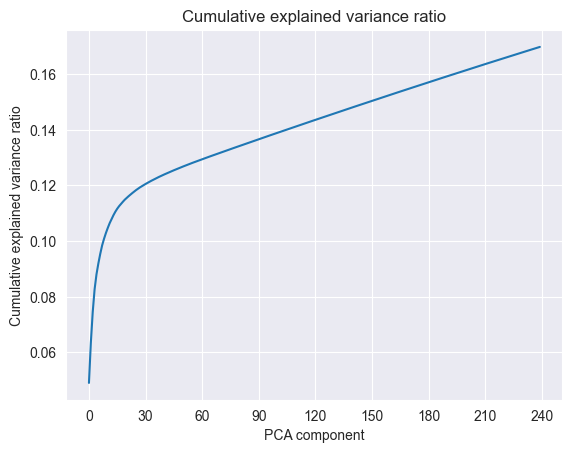

(70988, 240)


In [16]:
cite_train_x = preprocessor.fit_transform(pd.read_hdf(FP_CITE_TRAIN_INPUTS).values)

In [23]:
del cite_train_x
gc.collect()

42

In [24]:
cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values
print(cite_train_y.shape)

(70988, 140)


In [25]:
import pandas as pd

In [26]:
cite_train_x_hdf = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [28]:
cite_train_x_hdf

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000


In [29]:
all_zero_columns = (pd.read_hdf(FP_CITE_TRAIN_INPUTS).values ==0).all(axis=0)

In [30]:
cite_train_x_hdf = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [31]:
unit_x = cite_train_x_hdf.iloc[:,:100]

In [32]:
unit_x.corr().mean().sort_values(ascending=False)

gene_id
ENSG00000204574_ABCF1         0.050908
ENSG00000164163_ABCE1         0.049118
ENSG00000090861_AARS          0.044895
ENSG00000149313_AASDHPPT      0.042898
ENSG00000033050_ABCF2         0.041930
                                ...   
ENSG00000129673_AANAT         0.009382
ENSG00000154262_ABCA6         0.009031
ENSG00000225969_ABHD11-AS1    0.008904
ENSG00000264031_ABHD15-AS1         NaN
ENSG00000173210_ABLIM3             NaN
Length: 100, dtype: float64

In [34]:
unit_x

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000154175_ABI3BP,ENSG00000097007_ABL1,ENSG00000143322_ABL2,ENSG00000099204_ABLIM1,ENSG00000173210_ABLIM3,ENSG00000175164_ABO,ENSG00000159842_ABR,ENSG00000146386_ABRACL,ENSG00000163322_ABRAXAS1,ENSG00000165660_ABRAXAS2
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,4.090185,0.000000,5.686144,4.090185,4.090185
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,7.018410,0.000000,4.039545
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,3.847321,3.847321,3.847321,0.000000,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,0.0,0.00000,3.436846,0.000000,0.0,0.000000,0.000000,5.487739,3.436846,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.0,3.51861,0.000000,3.518610,0.0,0.000000,0.000000,5.889190,0.000000,3.518610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,4.397535,0.0,0.000000,0.000000,6.332840,4.397535,0.000000
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,5.575866,3.981467,3.981467
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.0,0.00000,0.000000,0.000000,0.0,3.815622,3.815622,4.899442,4.497696,0.000000


In [49]:
cite_train_x_hdf.columns

Index(['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1',
       'ENSG00000175899_A2M', 'ENSG00000245105_A2M-AS1',
       'ENSG00000166535_A2ML1', 'ENSG00000128274_A4GALT',
       'ENSG00000094914_AAAS', 'ENSG00000081760_AACS', 'ENSG00000109576_AADAT',
       'ENSG00000103591_AAGAB',
       ...
       'ENSG00000153975_ZUP1', 'ENSG00000086827_ZW10',
       'ENSG00000174442_ZWILCH', 'ENSG00000122952_ZWINT',
       'ENSG00000198205_ZXDA', 'ENSG00000198455_ZXDB', 'ENSG00000070476_ZXDC',
       'ENSG00000162378_ZYG11B', 'ENSG00000159840_ZYX',
       'ENSG00000074755_ZZEF1'],
      dtype='object', name='gene_id', length=22050)

In [50]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).values

In [51]:
X = X[:,~all_zero_columns]

In [60]:
all_zero_columns = (cite_train_x == 0).all(axis=0)

In [61]:
all_zero_columns

array([False, False, False, ..., False, False, False])

In [62]:

cite_train_x = cite_train_x[:,~all_zero_columns]

In [63]:
cite_train_x

array([[0.       , 0.       , 0.       , ..., 0.       , 4.090185 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 3.8473213, 3.8473213,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 4.497696 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        3.9009068],
       [0.       , 0.       , 0.       , ..., 0.       , 4.1895022,
        4.1895022]], dtype=float32)

In [64]:
cite_train_x

array([[0.       , 0.       , 0.       , ..., 0.       , 4.090185 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 3.8473213, 3.8473213,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 4.497696 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        3.9009068],
       [0.       , 0.       , 0.       , ..., 0.       , 4.1895022,
        4.1895022]], dtype=float32)

In [65]:
cite_train_x

array([[0.       , 0.       , 0.       , ..., 0.       , 4.090185 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 3.8473213, 3.8473213,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 4.497696 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        3.9009068],
       [0.       , 0.       , 0.       , ..., 0.       , 4.1895022,
        4.1895022]], dtype=float32)

In [66]:

display(cite_train_x_hdf.head())
print('Output shape:', cite_train_x_hdf.shape)

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,4.090185,0.0
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.00000,0.000000,0.000000,0.0
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.0,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.00000,3.847321,3.847321,0.0
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.0,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.00000,3.436846,4.113780,0.0
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.0,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.51861,4.196826,3.518610,0.0


Output shape: (70988, 22050)


In [67]:
cite_train_x_hdf(X == 0).all(axis=0)

TypeError: 'DataFrame' object is not callable

In [68]:
cite_train_x_hdf

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000


In [69]:
col = cite_train_x_hdf.columns[:20].tolist()

In [70]:
cite_train_x_hdf



gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000


In [71]:
# cite_train_x_hdf[col].loc[cite_train_x_hdf[col ] !=0].describe()
cols= cite_train_x_hdf.columns.tolist()

In [204]:
for col in cols[:10]:
    print(cite_train_x_hdf[col].loc[cite_train_x_hdf[col ] !=0].describe())

count    1627.000000
mean        3.754379
std         0.372747
min         3.001955
25%         3.479502
50%         3.738200
75%         4.011266
max         5.402543
Name: ENSG00000121410_A1BG, dtype: float64
count    3785.000000
mean        3.734334
std         0.371922
min         2.972577
25%         3.457813
50%         3.702939
75%         3.966665
max         5.697094
Name: ENSG00000268895_A1BG-AS1, dtype: float64
count    319.000000
mean       3.906690
std        0.483600
min        3.092428
25%        3.576060
50%        3.826980
75%        4.158049
max        6.385898
Name: ENSG00000175899_A2M, dtype: float64
count    3132.000000
mean        3.792779
std         0.387573
min         2.977233
25%         3.511813
50%         3.756107
75%         4.036302
max         5.565943
Name: ENSG00000245105_A2M-AS1, dtype: float64
count    25.000000
mean      3.822214
std       0.241728
min       3.431011
25%       3.667524
50%       3.830811
75%       3.908867
max       4.376676
Name: 

In [209]:

cite_train_x_hdf['ENSG00000109576_AADAT'].loc[cite_train_x_hdf['ENSG00000109576_AADAT']!=0].describe()

count    5391.000000
mean        3.768935
std         0.378243
min         2.972577
25%         3.499476
50%         3.735960
75%         4.000703
max         5.365835
Name: ENSG00000109576_AADAT, dtype: float64

In [210]:

cite_train_x_hdf['ENSG00000109576_AADAT'].loc[cite_train_x_hdf['ENSG00000109576_AADAT']==0].describe()

count    65597.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: ENSG00000109576_AADAT, dtype: float64

In [198]:
cite_train_x_hdf[col].loc[cite_train_x_hdf[col ] !=0]

cell_id
45006fe3e4c8    4.090185
d02759a80ba2    4.039545
fbcf2443ffb2    3.518610
1ac2049b4c98    4.048356
33fb0c29e2e4    4.392134
                  ...   
041ad6f0001a    3.687361
2e0bd42d269c    3.559876
38389b6b1127    4.780538
cc8aca070ab2    3.505268
a91f1b55a520    4.497696
Name: ENSG00000157426_AASDH, Length: 26263, dtype: float32

NameError: name 'col' is not defined

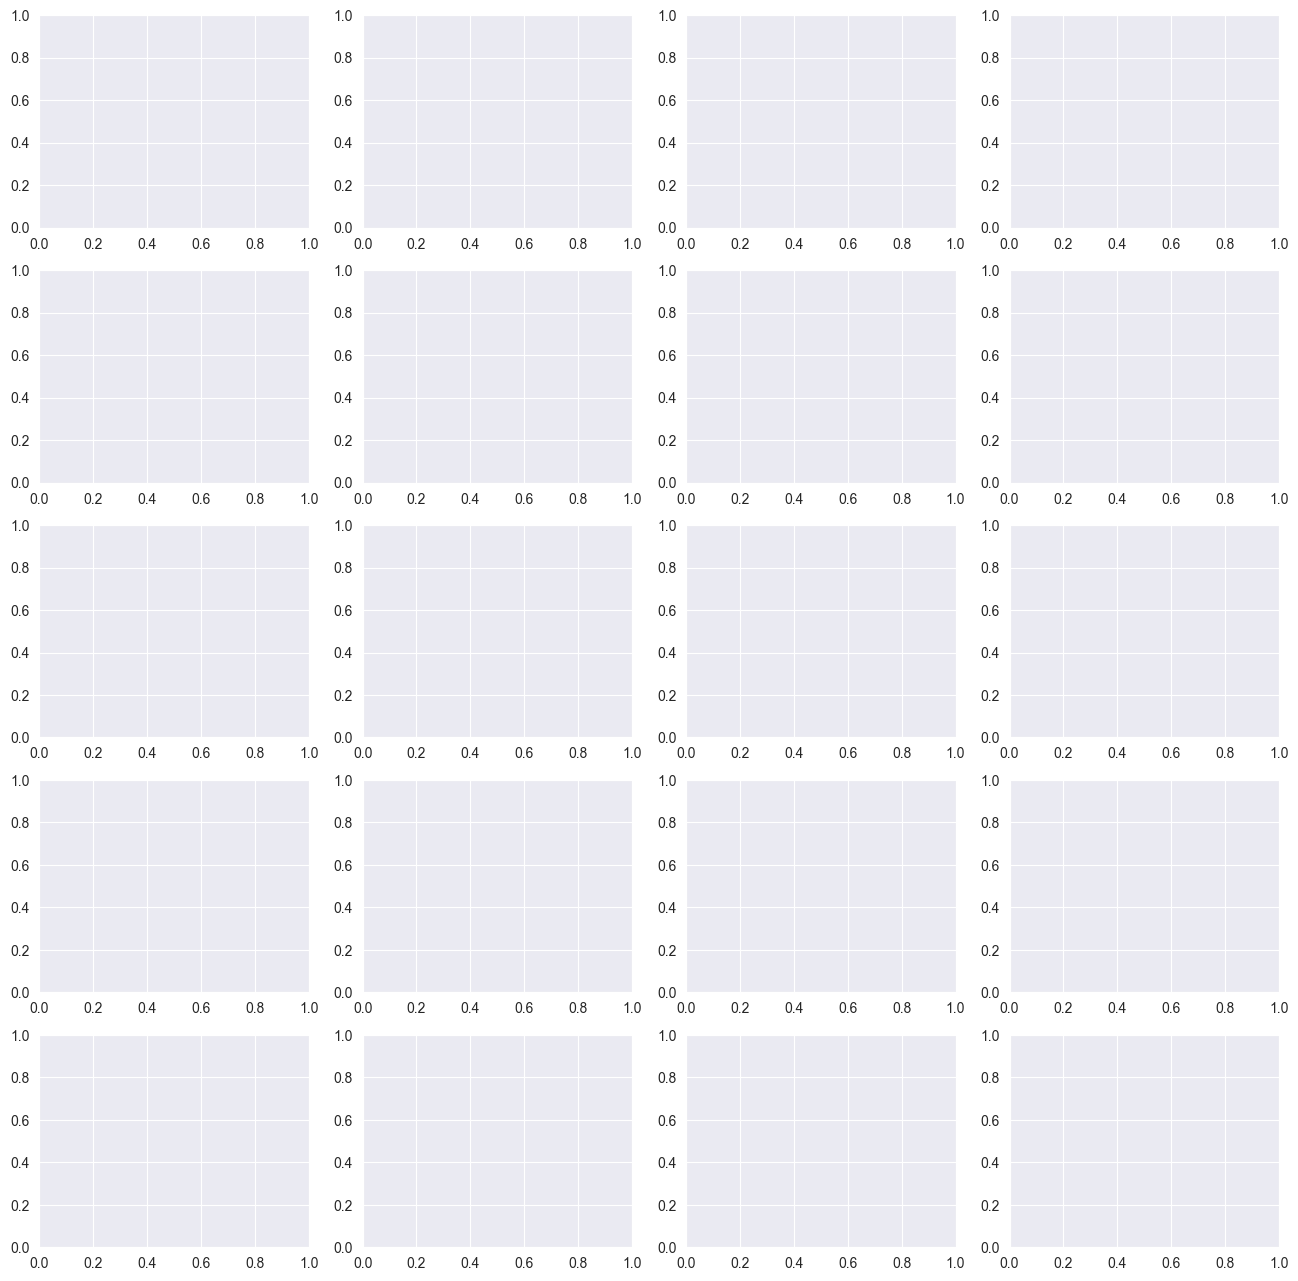

In [29]:
_, axs = plt.subplots(5, 4, figsize=(16, 16))
for col, ax in zip(col, axs.ravel()):

    ax.hist(cite_train_x_hdf[col], bins=100, density=True)
    ax.set_title(col)
plt.tight_layout(h_pad=2)
plt.suptitle('Selected target histograms (surface protein levels)', fontsize=20, y=1.04)
plt.show()

In [154]:
from sklearn.manifold import TSNE


# 2차원 t-SNE 임베딩
# 특히 고차원을 임베딩하는데 좋다
tsne_np = TSNE(n_components = 3).fit_transform(cite_train_x_hdf.values)

c:\users\data\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\data\appdata\local\programs\python\python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(

KeyboardInterrupt



array([[0.       , 0.       , 0.       , ..., 0.       , 4.090185 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 3.8473213, 3.8473213,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 4.497696 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        3.9009068],
       [0.       , 0.       , 0.       , ..., 0.       , 4.1895022,
        4.1895022]], dtype=float32)

In [28]:
cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values
print(cite_train_y.shape)

(70988, 140)


In [31]:
cite_train_x_hdf = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [32]:
cite_train_x_hdf

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000


In [91]:
pd.DataFrame(cite_train_y).corr().quantile(0.99).sort_values(ascending=False)

138    0.815857
108    0.740674
110    0.737685
97     0.707223
119    0.673603
         ...   
85     0.102387
33     0.101771
34     0.098439
84     0.089389
19     0.075771
Name: 0.99, Length: 140, dtype: float64

In [84]:
y_df = pd.DataFrame(cite_train_y)

In [96]:
y_df.corr()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,1.000000,0.065325,0.075298,0.112736,0.084708,0.132777,0.301286,0.048008,0.039475,0.109858,...,0.052656,0.094544,0.037857,0.086714,0.198925,0.063949,0.003345,0.277128,-0.053687,0.088765
1,0.065325,1.000000,0.264809,0.140884,0.112657,0.065413,-0.027188,0.161715,0.270617,0.125194,...,0.205164,0.055029,0.216886,0.258852,0.042335,0.221486,0.134908,0.133606,0.206977,0.175794
2,0.075298,0.264809,1.000000,0.294972,0.235210,0.173076,0.037174,0.213361,0.394816,0.201015,...,0.230121,0.190674,0.304055,0.287025,0.061454,0.323635,0.287165,0.166684,0.352414,0.302839
3,0.112736,0.140884,0.294972,1.000000,0.621655,0.453057,0.314290,0.105574,0.259327,0.253111,...,0.132740,0.420562,0.162367,0.214365,0.049744,0.266726,0.265603,0.158640,0.150125,0.444210
4,0.084708,0.112657,0.235210,0.621655,1.000000,0.496515,0.326109,0.126814,0.172926,0.291199,...,0.135582,0.303669,0.029437,0.235231,0.044869,0.225924,0.070174,0.142907,-0.081457,0.353021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.063949,0.221486,0.323635,0.266726,0.225924,0.174557,0.042835,0.196570,0.340098,0.198689,...,0.204017,0.147855,0.254109,0.249695,0.048152,1.000000,0.240479,0.142223,0.274970,0.265468
136,0.003345,0.134908,0.287165,0.265603,0.070174,0.119754,-0.122642,0.149752,0.292969,0.095816,...,0.093729,0.292801,0.257289,0.110125,-0.024129,0.240479,1.000000,-0.006108,0.442668,0.288597
137,0.277128,0.133606,0.166684,0.158640,0.142907,0.166546,0.332668,0.071859,0.141015,0.185745,...,0.121352,0.141976,0.097252,0.181408,0.378041,0.142223,-0.006108,1.000000,0.008480,0.156781
138,-0.053687,0.206977,0.352414,0.150125,-0.081457,-0.146187,-0.240930,0.155223,0.459538,-0.098437,...,0.099725,0.205319,0.517342,0.037619,-0.028664,0.274970,0.442668,0.008480,1.000000,0.274368


In [ ]:
import seaborn as sns

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,1.000000,0.065325,0.075298,0.112736,0.084708,0.132777,0.301286,0.048008,0.039475,0.109858,...,0.052656,0.094544,0.037857,0.086714,0.198925,0.063949,0.003345,0.277128,-0.053687,0.088765
1,0.065325,1.000000,0.264809,0.140884,0.112657,0.065413,-0.027188,0.161715,0.270617,0.125194,...,0.205164,0.055029,0.216886,0.258852,0.042335,0.221486,0.134908,0.133606,0.206977,0.175794
2,0.075298,0.264809,1.000000,0.294972,0.235210,0.173076,0.037174,0.213361,0.394816,0.201015,...,0.230121,0.190674,0.304055,0.287025,0.061454,0.323635,0.287165,0.166684,0.352414,0.302839
3,0.112736,0.140884,0.294972,1.000000,0.621655,0.453057,0.314290,0.105574,0.259327,0.253111,...,0.132740,0.420562,0.162367,0.214365,0.049744,0.266726,0.265603,0.158640,0.150125,0.444210
4,0.084708,0.112657,0.235210,0.621655,1.000000,0.496515,0.326109,0.126814,0.172926,0.291199,...,0.135582,0.303669,0.029437,0.235231,0.044869,0.225924,0.070174,0.142907,-0.081457,0.353021
5,0.132777,0.065413,0.173076,0.453057,0.496515,1.000000,0.458896,0.047551,0.112325,0.334668,...,0.090823,0.353186,0.000224,0.184479,0.061505,0.174557,0.119754,0.166546,-0.146187,0.272165
6,0.301286,-0.027188,0.037174,0.314290,0.326109,0.458896,1.000000,-0.026045,-0.020474,0.158636,...,0.024223,0.359787,-0.074782,0.079358,0.200849,0.042835,-0.122642,0.332668,-0.240930,0.175546
7,0.048008,0.161715,0.213361,0.105574,0.126814,0.047551,-0.026045,1.000000,0.210507,0.099640,...,0.125232,0.026660,0.155663,0.140971,0.054475,0.196570,0.149752,0.071859,0.155223,0.141721
8,0.039475,0.270617,0.394816,0.259327,0.172926,0.112325,-0.020474,0.210507,1.000000,0.140177,...,0.264325,0.192788,0.354536,0.320215,0.027683,0.340098,0.292969,0.141015,0.459538,0.296821
9,0.109858,0.125194,0.201015,0.253111,0.291199,0.334668,0.158636,0.099640,0.140177,1.000000,...,0.133755,0.052182,0.049649,0.217250,0.100822,0.198689,0.095816,0.185745,-0.098437,0.205584


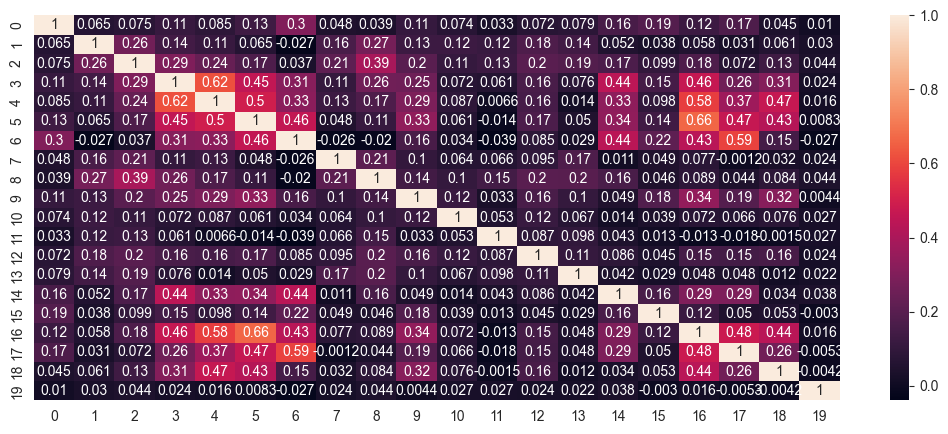

In [111]:
plt.figure(figsize=(13,5))
sns.heatmap(y_df.corr().iloc[:20,:20],annot=True)
plt.show()

In [120]:
cite_train_x_hdf.iloc[0].values.mean()

0.8210808

In [17]:
cite_train_x_hdf = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [32]:
cite_train_x = preprocessor.fit_transform(cite_train_x_hdf.values)

(70988, 22051)


array([[0.        , 0.        , 0.        , ..., 4.090185  , 0.        ,
        0.8210808 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.79217654],
       [0.        , 0.        , 0.        , ..., 3.8473213 , 0.        ,
        0.9402288 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.030994  ],
       [0.        , 0.        , 0.        , ..., 0.        , 3.9009068 ,
        1.0643936 ],
       [0.        , 0.        , 0.        , ..., 4.1895022 , 4.1895022 ,
        0.85313606]], dtype=float32)

In [ ]:
y_df.corr().iloc[138].sort_values(ascending=False)

In [89]:
y_df.corr().iloc[97].sort_values(ascending=False)

97     1.000000
119    0.714796
3      0.695378
100    0.673920
4      0.623746
         ...   
44     0.052870
85     0.051659
101    0.036280
53     0.024324
19     0.021254
Name: 97, Length: 140, dtype: float64

NameError: name 'cite_train_x_hdf' is not defined

In [127]:
cite_train_x

array([[0.       , 0.       , 0.       , ..., 0.       , 4.090185 ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 3.8473213, 3.8473213,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 4.497696 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        3.9009068],
       [0.       , 0.       , 0.       , ..., 0.       , 4.1895022,
        4.1895022]], dtype=float32)

In [36]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(cite_train_x)):
    model = None
    gc.collect()
    X_tr = cite_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = cite_train_y[idx_tr]
    # ridge 자체가 정규화 사용
    model = Ridge(copy_X=False) # overwrites the copied data
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = cite_train_x[idx_va]
    y_va = cite_train_y[idx_va]
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va
    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")

c:\users\data\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.78659e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


NameError: name 'correlation_score' is not defined

(70988, 22051)
(70988, 21602)
(70988, 12000)


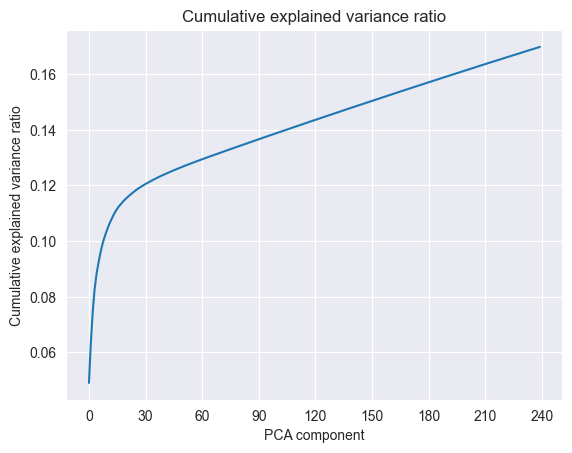

(70988, 240)
(70988, 140)
CPU times: total: 6min 30s
Wall time: 1min 22s


In [3]:
%%time
# Preprocessing

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 12000

    @staticmethod
    def take_column_subset(X):
        return X[:,-PreprocessCiteseq.columns_to_use:]

    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=240, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)
        return X

preprocessor = PreprocessCiteseq()

cite_train_x = None

cite_train_x_hdf=pd.read_hdf(FP_CITE_TRAIN_INPUTS)
cite_train_x_hdf['mean'] = cite_train_x_hdf.apply(lambda x: x.mean(),axis=1)
cite_train_x = preprocessor.fit_transform(cite_train_x_hdf.values)

cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values
print(cite_train_y.shape)

In [4]:
cite_train_x_hdf

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1,mean
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000,0.821081
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.792177
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000,0.940229
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000,1.135173
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000,1.155327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535,0.706909
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000,0.950521
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000,1.030994


In [ ]:
# 어떤 y값을 가지는 셀들의 특징은 무엇일까


In [23]:
cite_train_y_hdf = pd.DataFrame(cite_train_y)

In [23]:
#
# 6 번째 y값이 21인 x 셀의 0인 유전자 개수는 16169개
# cite_train_x_hdf.iloc[3][(cite_train_x_hdf.iloc[3] == 0).values]
# 평균적으로 x셀 0인 유전자 개수는 ?

gene_id
ENSG00000121410_A1BG        0.0
ENSG00000268895_A1BG-AS1    0.0
ENSG00000175899_A2M         0.0
ENSG00000245105_A2M-AS1     0.0
ENSG00000166535_A2ML1       0.0
                           ... 
ENSG00000086827_ZW10        0.0
ENSG00000198205_ZXDA        0.0
ENSG00000198455_ZXDB        0.0
ENSG00000070476_ZXDC        0.0
ENSG00000074755_ZZEF1       0.0
Name: ba7f733a4f75, Length: 16169, dtype: float32

In [ ]:
cnt = 0

In [6]:
list_15000_16000= []

In [5]:
cite_train_y


array([[ 1.1678035 ,  0.62253   ,  0.10695851, ...,  0.41429165,
         1.780314  ,  0.5480701 ],
       [ 0.81897014,  0.50600946,  1.078682  , ...,  0.9823084 ,
         2.736507  ,  2.1840627 ],
       [-0.3567033 , -0.42226133, -0.82449275, ..., -1.182975  ,
         3.958148  ,  2.8686    ],
       ...,
       [ 1.2213128 ,  0.47656643,  1.4375515 , ...,  0.98188305,
         6.911032  ,  3.4153101 ],
       [-0.15143251, -0.850024  ,  0.46155566, ...,  1.0102471 ,
         1.8648046 ,  3.4492888 ],
       [-0.4392985 , -0.33832696,  0.80367655, ...,  0.6188518 ,
         7.220644  ,  3.2343602 ]], dtype=float32)

In [7]:
!pip install --quiet tables

In [8]:
for idx in range(len(cite_train_x_hdf.columns.tolist())):
    # print(len(cite_train_x_hdf.iloc[idx][(cite_train_x_hdf.iloc[idx] ==0).values]))
    if 15000 < len(cite_train_x_hdf.iloc[idx][(cite_train_x_hdf.iloc[idx] ==0).values]) < 16000:
        list_15000_16000.append(idx)
    cnt+=1
    if cnt ==1000:
        break

18226
18342
17438
16169
16209
16421
18004
15344
16856
18153
17150
15928
17923
17076
14795
16907
17333
14979
16129
17528
16478
17133
16548
17261
16543
15972
17972
16542
18603
17600
16513
15837
17185
16108
17845
16372
16785
17948
17215
16760
18747
15318
16237
17964
16406
16451
17264
17660
15335
16347
17033
17558
16384
17108
15097
18141
17393
16137
17165
16032
17304
16258
16840
17127
16958
16864
15947
17577
18764
17550
17317
15502
18576
16842
17679
16711
17920
16403
16405
17048
17398
15820
17149
17368
18149
16940
17791
16058
16826
16479
16883
16815
16147
16005
16582
16881
16418
17742
16381
16418
17542
18435
16784
17674
17452
16226
15307
17463
16575
15743
17818
16629
17490
14964
17686
16787
16880
16374
16975
17875
17776
15384
16378
16048
15526
16445
16248
17446
17955
17511
16871
17234
16422
16449
18082
17486
16993
17820
16043
17215
16147
16671
18711
15627
16279
16754
15817
16341
17361
18678
18016
15940
16118
16741
17856
16019
15646
16349
17722
17593
15448
16769
17114
18461
17757
16515
1700

In [14]:
len(list_15000_16000)

156

In [16]:
# 다른 셀들보다 육안을 봤을 때 상관계수가 조금씩 더 높다, 그래서?
cite_train_x_hdf.iloc[list_15000_16000,:].T.corr()

cell_id,33fb0c29e2e4,8dbe30c95702,f64f24ba925a,ea1975bd6055,87229342150a,755f28c0c23b,871058f78714,e8ac1c9075ba,e5a992302262,2682063a02ac,...,886ded0035e5,7ea9ffa4d667,0dec52bc3047,8ebb59deb9c7,92d005ad5e52,9e43e9320097,d79de0a0adbc,a8bfa2c896b6,0d3fde725f7d,745f223d3715
cell_id,,,,,,,,,,,,,,,,,,,,,
33fb0c29e2e4,1.000000,0.682314,0.682258,0.674854,0.698912,0.697487,0.708090,0.684136,0.699053,0.690582,...,0.698431,0.704666,0.674529,0.700909,0.701941,0.681223,0.691336,0.682290,0.695209,0.700595
8dbe30c95702,0.682314,1.000000,0.678744,0.681318,0.679391,0.678913,0.705713,0.676583,0.674089,0.684178,...,0.678620,0.690649,0.663548,0.689739,0.682091,0.671120,0.694943,0.671352,0.692540,0.696341
f64f24ba925a,0.682258,0.678744,1.000000,0.663474,0.680725,0.681710,0.690564,0.682486,0.665684,0.682638,...,0.673793,0.682244,0.649094,0.682257,0.680167,0.663313,0.689079,0.674022,0.680674,0.686641
ea1975bd6055,0.674854,0.681318,0.663474,1.000000,0.673707,0.667111,0.701670,0.658027,0.664538,0.672651,...,0.658859,0.671231,0.644590,0.665990,0.668743,0.659376,0.680241,0.653426,0.670288,0.685785
87229342150a,0.698912,0.679391,0.680725,0.673707,1.000000,0.695189,0.707371,0.673944,0.697172,0.683820,...,0.689352,0.701451,0.661970,0.694066,0.696308,0.673589,0.684633,0.678944,0.701154,0.695439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9e43e9320097,0.681223,0.671120,0.663313,0.659376,0.673589,0.679309,0.695055,0.674097,0.677825,0.675475,...,0.667990,0.683976,0.655388,0.672416,0.688490,1.000000,0.677743,0.695542,0.691432,0.703056
d79de0a0adbc,0.691336,0.694943,0.689079,0.680241,0.684633,0.684295,0.715158,0.680969,0.676142,0.688055,...,0.685889,0.690980,0.662225,0.690678,0.696277,0.677743,1.000000,0.691226,0.704005,0.708783
a8bfa2c896b6,0.682290,0.671352,0.674022,0.653426,0.678944,0.678115,0.693113,0.673159,0.682084,0.673530,...,0.680350,0.680630,0.652278,0.686727,0.695360,0.695542,0.691226,1.000000,0.697397,0.693903


In [25]:
cite_train_x_15 = cite_train_x_hdf.iloc[list_15000_16000,:]

In [26]:
cite_train_y_15 = cite_train_y_hdf.iloc[list_15000_16000,:]

In [ ]:
cite_train_x_hdf

In [ ]:
# 4번째로
#상관관계가 높은 셀들을 볼까
cite_train_x_hdf.T.corr()

In [38]:
# 똑같은 0의 개수를 가지는 셀이 있네
# 하나의 사례를 탐구해보기


9

In [43]:
len(cite_train_x_hdf.iloc[19][(cite_train_x_hdf.iloc[19] ==0).values])

17528

In [41]:

len(cite_train_x_hdf.iloc[idx][(cite_train_x_hdf.iloc[idx] ==0).values])

18153

In [33]:
cite_train_x_hdf.iloc[3]

gene_id
ENSG00000121410_A1BG        0.000000
ENSG00000268895_A1BG-AS1    0.000000
ENSG00000175899_A2M         0.000000
ENSG00000245105_A2M-AS1     0.000000
ENSG00000166535_A2ML1       0.000000
                              ...   
ENSG00000070476_ZXDC        0.000000
ENSG00000162378_ZYG11B      3.436846
ENSG00000159840_ZYX         4.113780
ENSG00000074755_ZZEF1       0.000000
mean                        1.135173
Name: ba7f733a4f75, Length: 22051, dtype: float32

In [ ]:

cite_train_x_hdf.iloc[4][(cite_train_x_hdf.iloc[4] ==0).values]

In [24]:
cite_train_x_hdf.iloc[3][(cite_train_x_hdf.iloc[3] != 0).values]

gene_id
ENSG00000094914_AAAS      3.436846
ENSG00000081760_AACS      3.436846
ENSG00000115977_AAK1      4.513782
ENSG00000087884_AAMDC     3.436846
ENSG00000127837_AAMP      4.798720
                            ...   
ENSG00000174442_ZWILCH    4.113780
ENSG00000122952_ZWINT     5.020215
ENSG00000162378_ZYG11B    3.436846
ENSG00000159840_ZYX       4.113780
mean                      1.135173
Name: ba7f733a4f75, Length: 5882, dtype: float32

In [13]:
cite_train_y_hdf.iloc[3]

NameError: name 'cite_train_y_hdf' is not defined

In [ ]:
cite_train_x_15,cite_train_y_15

In [ ]:
cite_train_x = cite_train_x_15.values

In [14]:
cite_train_y=  cite_train_y_15.values

NameError: name 'cite_train_y_15' is not defined

In [15]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(cite_train_x)):
    model = None
    gc.collect()
    X_tr = cite_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = cite_train_y[idx_tr]

    model = Ridge(copy_X=False) # overwrites the copied data
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = cite_train_x[idx_va]
    y_va = cite_train_y[idx_va]
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")

"""
# 유전자 평균 값을 추가한 training 결과
Fold 0: mse = 2.29565, corr =  0.902
Fold 1: mse = 2.99642, corr =  0.874
Fold 2: mse = 3.29957, corr =  0.874
Fold 3: mse = 3.49369, corr =  0.878
Fold 4: mse = 2.72927, corr =  0.885
Average  mse = 2.96292; corr = 0.882
CPU times: total: 2.27 s
Wall time: 1.96 s
"""

NameError: name 'cite_train_x' is not defined

In [ ]:
# 비슷한 활성세포 수들 끼리는 비슷한 y값을 내놓는다 , 근데 값이 왜저래 ?
# 장족의 발전 이런 거라도,
# 아니 근데 해석이 잘못된걸수도 당연히 비슷한 값을 넣어서? 글쎄 활성 유전자의 수만 따졌는데 , 과적합인가


In [ ]:
"""
ORIGIN
Fold 0: mse = 2.66915, corr =  0.888
Fold 1: mse = 2.67049, corr =  0.888
Fold 2: mse = 2.66776, corr =  0.889
Fold 3: mse = 2.69190, corr =  0.888
Fold 4: mse = 2.67253, corr =  0.887
Average  mse = 2.67437; corr = 0.888
CPU times: total: 8.39 s
Wall time: 7.01 s
"""

In [262]:
cite_train_x_hdf

gene_id,ENSG00000121410_A1BG,ENSG00000268895_A1BG-AS1,ENSG00000175899_A2M,ENSG00000245105_A2M-AS1,ENSG00000166535_A2ML1,ENSG00000128274_A4GALT,ENSG00000094914_AAAS,ENSG00000081760_AACS,ENSG00000109576_AADAT,ENSG00000103591_AAGAB,...,ENSG00000153975_ZUP1,ENSG00000086827_ZW10,ENSG00000174442_ZWILCH,ENSG00000122952_ZWINT,ENSG00000198205_ZXDA,ENSG00000198455_ZXDB,ENSG00000070476_ZXDC,ENSG00000162378_ZYG11B,ENSG00000159840_ZYX,ENSG00000074755_ZZEF1
cell_id,,,,,,,,,,,,,,,,,,,,,
45006fe3e4c8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,4.090185,0.000000
d02759a80ba2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.039545,0.0,0.0,0.000000,0.000000,0.000000,0.000000
c016c6b0efa5,0.0,0.0,0.0,0.0,0.0,3.847321,0.000000,3.847321,3.847321,0.000000,...,0.000000,0.000000,3.847321,4.529743,0.0,0.0,0.000000,3.847321,3.847321,0.000000
ba7f733a4f75,0.0,0.0,0.0,0.0,0.0,0.000000,3.436846,3.436846,0.000000,0.000000,...,3.436846,0.000000,4.113780,5.020215,0.0,0.0,0.000000,3.436846,4.113780,0.000000
fbcf2443ffb2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.196826,0.000000,0.000000,...,0.000000,4.196826,4.196826,4.196826,0.0,0.0,3.518610,4.196826,3.518610,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650ee456f0f3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.397535,4.397535,5.084510,0.0,0.0,0.000000,0.000000,4.397535,4.397535
cc506e7707f5,0.0,0.0,0.0,0.0,0.0,0.000000,3.981467,4.665241,0.000000,0.000000,...,3.981467,0.000000,4.665241,3.981467,0.0,0.0,0.000000,0.000000,3.981467,0.000000
a91f1b55a520,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,4.497696,0.000000,4.497696,...,0.000000,0.000000,0.000000,4.497696,0.0,0.0,3.815622,4.497696,0.000000,0.000000


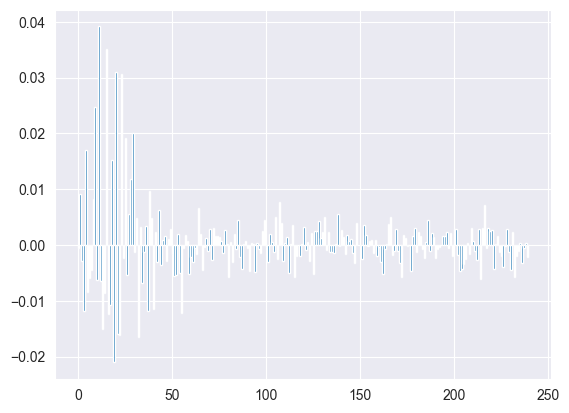

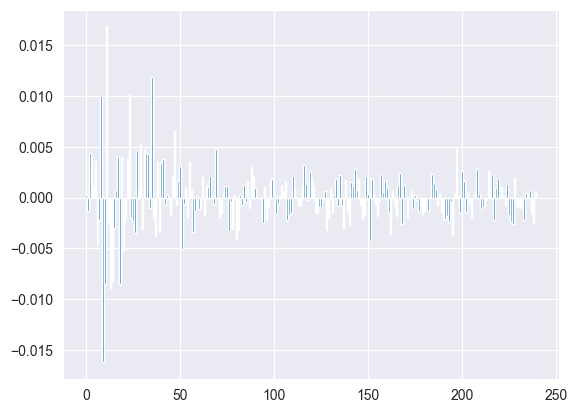

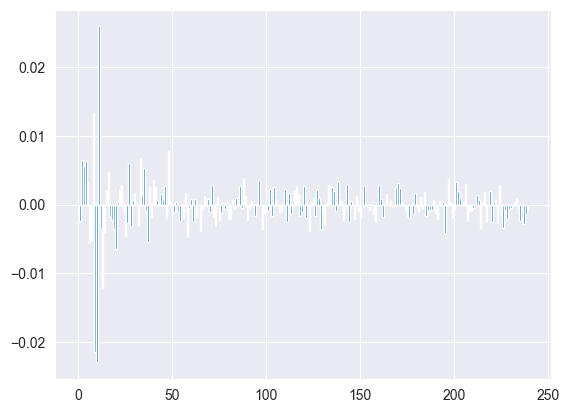

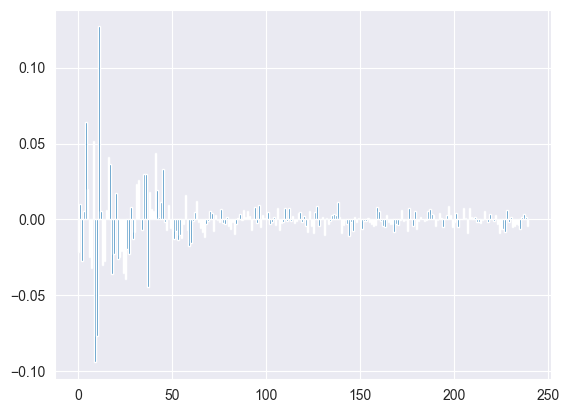

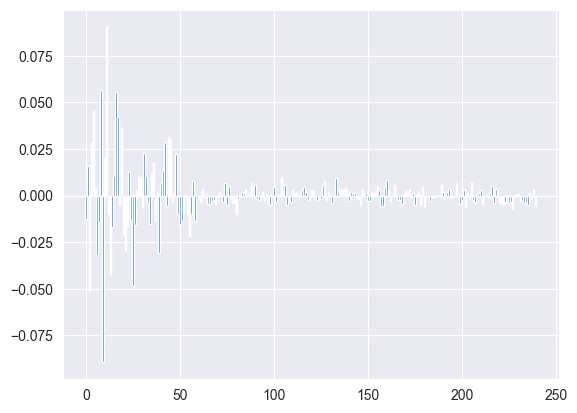

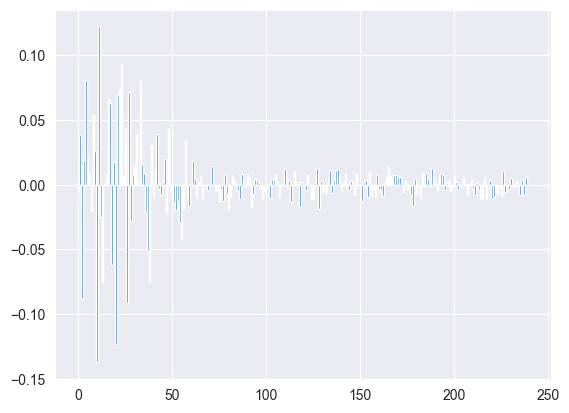

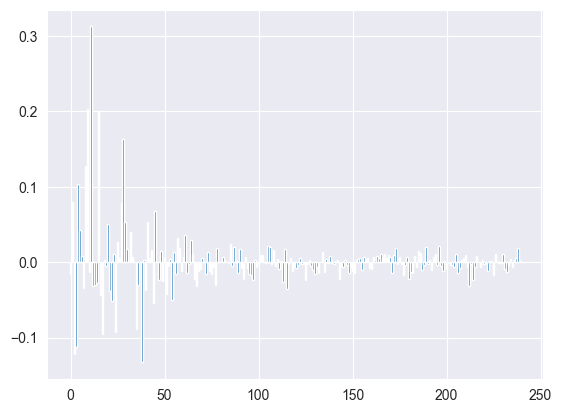

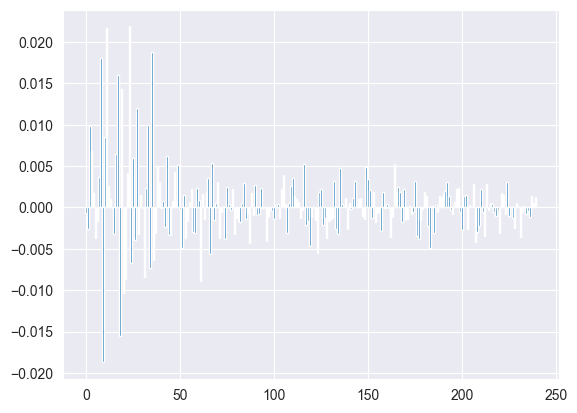

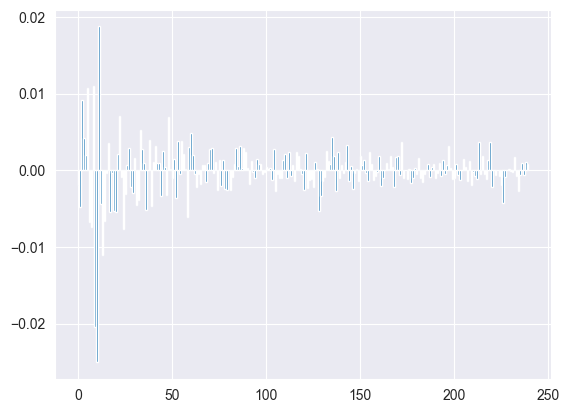

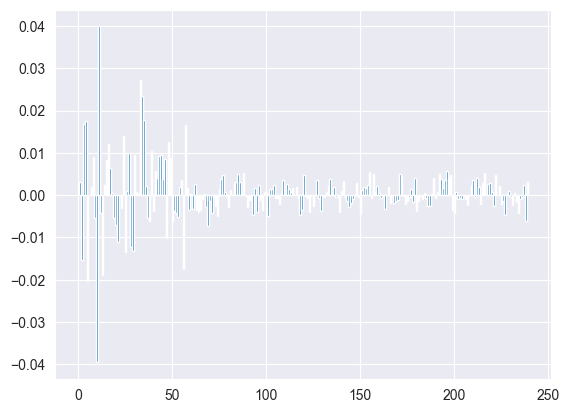

In [260]:
for i in range(10):
    importance = model.coef_[i]
    plt.bar([x for x in range(len(importance))],importance)
    plt.show((20,10))

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression,  Ridge
X, y = make_classification(n_samples=3000, n_features=10, n_informative=5, random_state=1)
X.shape, y.shape

((3000, 10), (3000,))

In [232]:
cite_train_x[idx_tr]

array([[ 2.6031538e+01, -2.2198727e+01, -1.4286908e+01, ...,
         2.9430053e+00, -2.3660476e+00,  3.4508376e+00],
       [ 1.8596578e+00, -3.5051968e+00,  2.6592810e+01, ...,
        -5.5647526e+00,  2.8078492e+00, -2.0709186e+00],
       [-3.2640041e+01,  4.2525992e+00, -1.5825752e+01, ...,
         4.7082931e-01,  1.2648261e-02,  5.9990625e+00],
       ...,
       [-1.0426436e+01, -2.4282904e+00,  3.2404007e+01, ...,
         3.7062330e+00,  1.6624441e+00,  2.3641834e+00],
       [-2.0742437e+01,  2.6664656e+01,  4.1004524e+00, ...,
        -1.8852141e-02,  1.1367649e+00,  4.5534182e+00],
       [ 1.9317869e+01, -8.0989847e+00,  2.7159540e+01, ...,
         2.7066019e+00,  1.7592092e+00,  6.1122733e-01]], dtype=float32)

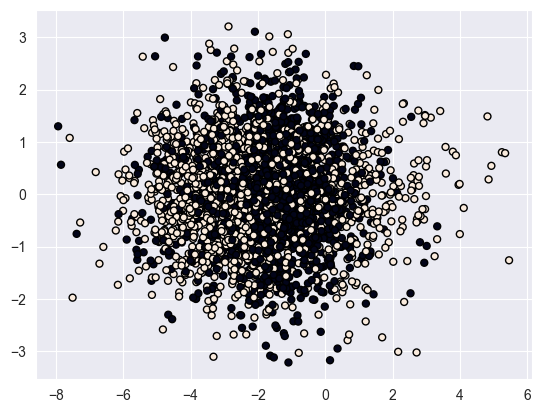

In [220]:
plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")

In [222]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2100, 10), (900, 10), (2100,), (900,))

In [223]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train, y_train)

StandardScaler()

In [249]:
ridge_logit =LogisticRegression(C=1, penalty='l2')
ridge_logit.fit(X_train, y_train)

LogisticRegression(C=1)

(2100, 10)

In [ ]:

X.shape, y.shape

array([[-0.00045886,  0.00920218, -0.00292159, ..., -0.00054597,
         0.00042959, -0.00217473],
       [ 0.00030668, -0.0013206 ,  0.00443301, ..., -0.00160129,
        -0.00251774,  0.00065407],
       [-0.00210754, -0.00237062,  0.00652352, ..., -0.00279543,
        -0.00140538, -0.00074893],
       ...,
       [ 0.00168653,  0.00800637, -0.00199707, ...,  0.00123122,
         0.00384614, -0.00391468],
       [-0.02496992, -0.03304978,  0.09664463, ..., -0.00482599,
        -0.00101311, -0.0007024 ],
       [-0.00938984,  0.00672457,  0.00841767, ..., -0.00179586,
         0.00066206, -0.00388609]], dtype=float32)

In [13]:
cite_train_x = preprocessor.fit_transform(pd.read_hdf(FP_CITE_TRAIN_INPUTS).values)

NameError: name 'preprocessor' is not defined

In [ ]:
# TIL : 차원축소되지 않으면 전혀 train 조차 할 수 없다


In [ ]:
model = None # free the RAM occupied by the old model
model = Ridge(copy_X=False) # we overwrite the training data
model.fit(cite_train_x, cite_train_y)
# del cite_train_x, cite_train_y
gc.collect()

In [20]:
cite_test_x = preprocessor.transform(pd.read_hdf(FP_CITE_TEST_INPUTS).values)

(48663, 22050)
(48663, 21601)
(48663, 12000)
(48663, 240)


In [ ]:
test_pred = model.predict(cite_test_x)
del cite_test_x
test_pred.shape

In [42]:
with open('citeseq_pred.pickle', 'wb') as f:
    pickle.dump(test_pred, f) # float32 array of shape (48663, 140)

AttributeError: 'Ridge' object has no attribute 'feature_names_in_'

In [46]:
with open("./input/", 'rb') as f: submission = pickle.load(f)
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()
submission = submission.round(6) # reduce the size of the csv
submission.to_csv('submission.csv')
submission

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [47]:
submission

array([[ 5.9643769e-01,  2.9957777e-01,  6.2443590e-01, ...,
         6.1054903e-01,  1.0359299e+00,  1.7766612e+00],
       [ 3.9337423e-01,  3.3834580e-01,  4.4844064e-01, ...,
         2.8508404e-01,  1.4411733e+00,  1.2989464e+00],
       [ 1.6099495e-01,  4.3669248e-01,  7.4779308e-01, ...,
        -3.0784011e-03,  6.6345243e+00,  2.5133383e+00],
       ...,
       [ 4.5800704e-01,  1.5703940e+00,  1.3568678e+00, ...,
         1.3112766e+00,  1.0515618e-01,  4.3781290e+00],
       [-2.6443022e-01,  4.6751750e-01,  9.5334464e-01, ...,
        -4.7403347e-01,  7.1337862e+00,  3.0998113e+00],
       [ 2.3139536e-02,  5.9047908e-01,  1.1516629e+00, ...,
         2.6848119e-01,  8.0112886e+00,  4.9272528e+00]], dtype=float32)

In [ ]:
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()
submission = submission.round(6) # reduce the size of the csv
submission.to_csv('submission.csv')
submission